# Treinamento DistilBERT - Fake News Classification - PS Ligia NLP
**Autor:** Carlos Eduardo Falcão Teixera (ceft)  
**Objetivo:** Realizar o Fine-Tuning de um modelo da família Transformer (DistilBERT) para detetar Fake News, mitigando vieses de desbalanceamento de classes e otimizando o uso de memória em GPU.

## Contexto e Decisões Técnicas
Após uma fase exaustiva de Análise Exploratória (EDA) e Pré-processamento, preparamos um dataset limpo e sem Data Leakage. Para a fase de modelagem, adotamos as seguintes premissas:

1. **Modelo Base**: Utilizaremos o `DistilBERT` (podendo ser facilmente substituído por `BERT` ou `RoBERTa`). Ele retém mais de 95% da performance do BERT original sendo 60% mais rápido, ideal para iterações em ambientes com recursos limitados como o Google Colab.

2. **Desbalanceamento (3:1)**: Em vez de realizar oversampling ou undersampling (que podem distorcer a distribuição de probabilidade original do texto), utilizaremos Class Weights injetados diretamente na Função de Perda (Cross-Entropy Loss) do modelo.

3. **Gestão de GPU:** Implementaremos Mixed Precision (`fp16=True`), Gradient Accumulation e limpeza estrita de cache (`torch.cuda.empty_cache()`) a cada iteração do nosso loop de treinamento para evitar o temido erro de Out Of Memory (OOM).

4. **Avaliação Focada:** A acurácia é uma métrica ilusória em datasets desbalanceados. Nosso norte será o F1-Score (Macro) e a área sob a curva ROC-AUC.

In [ ]:
# 1. INSTALAÇÃO E IMPORTAÇÃO DE BIBLIOTECAS
import os
import gc
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gdown
import zipfile

from google.colab import drive
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EvalPrediction
)
from datasets import Dataset

# Fixando a semente para reprodutibilidade total
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Montando o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carregamento e Split dos Dados
Aqui dividimos os dados na proporção 80% Treino, 10% Validação e 10% Teste. O conjunto de validação guiará o nosso loop de treino, enquanto o teste será um cofre fechado, usado apenas no final para simular dados do mundo real.

No final também aproveitamos para calcular os pesos do `class_weights`.

In [ ]:


USAR_DS_ONLINE = True

if not USAR_DS_ONLINE:
  # Carregamento do arquivo de Treino via Google Drive (Utilize caso não tenha executado o EDA)
  test_csv_path = '/content/drive/MyDrive/PS_Ligia_NLP/ligia_dataset_processado.csv'
  df = pd.read_csv(test_csv_path)

else:
  # --- Carregando do arquivo de Treino via compartilhamento Online
  url = 'https://drive.google.com/uc?id=15s3ejquDEvz0lUdWalZrHxZIDC3tlQGB'
  output = 'ligia_dataset_processado.csv'

  try:
    if not os.path.exists(output):
      gdown.download(url, output, quiet=False)

    df = pd.read_csv(output)
    print("\n✅ Dataset carregado com sucesso!")
  except Exception as e:
    print(f"❌ Erro ao baixar/ler o arquivo: {e}")

  # ---

# Carregamento
df = df.dropna(subset=['input_text', 'label']) # Garantia de segurança

print(f"Tamanho total do dataset: {len(df)} registros")

# Split 1: 80% Treino e 20% Temporário (para Validação e Teste)
df_train, df_temp = train_test_split(
    df, test_size=0.20, stratify=df['label'], random_state=RANDOM_STATE
)

# Split 2: Divide os 20% temporários em 10% Validação e 10% Teste
df_val, df_test = train_test_split(
    df_temp, test_size=0.50, stratify=df_temp['label'], random_state=RANDOM_STATE
)

print(f"Treino: {len(df_train)} | Validação: {len(df_val)} | Teste: {len(df_test)}")

# CÁLCULO DE CLASS WEIGHTS (Desbalanceamento)
# Calculamos os pesos apenas com base no Treino para evitar Data Leakage
classes = np.unique(df_train['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df_train['label'])
class_weights = torch.tensor(weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Pesos calculados para as classes (0 e 1): {weights}")

Downloading...
From: https://drive.google.com/uc?id=15s3ejquDEvz0lUdWalZrHxZIDC3tlQGB
To: /content/ligia_dataset_processado.csv
100%|██████████| 55.9M/55.9M [00:00<00:00, 83.2MB/s]



✅ Dataset carregado com sucesso!
Tamanho total do dataset: 22193 registros
Treino: 17754 | Validação: 2219 | Teste: 2220
Pesos calculados para as classes (0 e 1): [0.65310477 2.13286881]


## Tokenização e Criação do Dataset PyTorch
Os modelos baseados em BERT possuem um limite absoluto de 512 tokens.

**Justificativa de Truncamento**: Notícias longas (maiores que 512 palavras) terão o seu final cortado (`truncation=True`). Em jornalismo, o primeiro parágrafo contém o núcleo da informação (quem, o quê, quando, onde e por quê). Portanto, manter os primeiros 512 tokens (que geralmente cobrem título + primeiros parágrafos) retém a maior parte da densidade semântica para classificar uma notícia como real ou falsa.

In [ ]:

MODEL_NAME = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    # max_length=512 é o limite da arquitetura base.
    # padding='max_length' garante tensores do mesmo tamanho para a GPU.
    return tokenizer(
        examples["input_text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

# Convertendo Pandas para Hugging Face Datasets
ds_train = Dataset.from_pandas(df_train[['input_text', 'label']].reset_index(drop=True))
ds_val = Dataset.from_pandas(df_val[['input_text', 'label']].reset_index(drop=True))
ds_test = Dataset.from_pandas(df_test[['input_text', 'label']].reset_index(drop=True))

# Aplicando a tokenização (batched=True acelera o processo usando C++)
tokenized_train = ds_train.map(tokenize_function, batched=True, remove_columns=["input_text"])
tokenized_val = ds_val.map(tokenize_function, batched=True, remove_columns=["input_text"])
tokenized_test = ds_test.map(tokenize_function, batched=True, remove_columns=["input_text"])

# Data Collator para criar os batches de forma eficiente
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/17754 [00:00<?, ? examples/s]

Map:   0%|          | 0/2219 [00:00<?, ? examples/s]

Map:   0%|          | 0/2220 [00:00<?, ? examples/s]

## Funções Base: Métricas e Custom Trainer
Como não confiamos na Acurácia, injetaremos o cálculo do F1-Score (Macro) e ROC-AUC diretamente no loop de avaliação do Hugging Face. Além disso, criamos um `CustomTrainer` que reescreve o método `compute_loss` utilizando `class_weights` para punir o modelo mais severamente quando ele errar a classe minoritária.

In [ ]:
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    # Probabilidades para a classe 1 (necessário para ROC-AUC)
    # Aplicamos softmax nos logits para obter as probabilidades
    probs = torch.nn.functional.softmax(torch.tensor(p.predictions), dim=-1)[:, 1].numpy()

    f1_macro = f1_score(labels, preds, average='macro')
    roc_auc = roc_auc_score(labels, probs)

    return {
        'f1_macro': f1_macro,
        'roc_auc': roc_auc
    }

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropyLoss recebendo os class_weights calculados no passo anterior
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

## Automação do Treinamento
Justificativa de Hiperparâmetros e Gestão de Memória:

- **Learning Rate (2e-5 a 5e-5):** Esta é a recomendação de learning rate do BERT para Fine-Tuning. Valores maiores destruiriam os pesos pré-treinados.

- **Gradient Accumulation:** Permite simular um batch size maior (ex: 32) dividindo o forward/backward pass em mini-batches menores (ex: 8), poupando VRAM.

- **Limpeza de GPU:** Crucial no Colab. `del model` destrói a referência ao objeto, `gc.collect()` obriga o Python a limpar o lixo na RAM, e `torch.cuda.empty_cache()` libera a VRAM da placa de vídeo não alocada.

In [ ]:
from transformers import EarlyStoppingCallback
from transformers import logging as hf_logging

# Definindo o Grid de Hiperparâmetros
learning_rates = [3e-5, 5e-5, 7e-5]
MAX_EPOCHS = 5
batch_size = 16

# DataFrame para rastreio
results_log = []
best_val_loss = float('inf')
best_model_path = "/content/drive/MyDrive/PS_Ligia_NLP/best_distilbert_model"

print("🚀 Iniciando Treinamento...\n")

for lr in learning_rates:
        print(f"🔄 Testando Combinação: LR={lr}")

        # TRUQUE DE LOG: Desligar avisos
        hf_logging.set_verbosity_error()

        # Instanciar um modelo "fresco" para cada teste
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

        # TRUQUE DE LOG: Ligar avisos novamente para manter as barras de progresso
        hf_logging.set_verbosity_warning()

        # 2. Configurar TrainingArguments (com as seeds de reprodutibilidade e save_total_limit)
        training_args = TrainingArguments(
            output_dir='./results_temp',
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=MAX_EPOCHS,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            save_total_limit=2, # Mantém apenas os 2 melhores checkpoints para não encher a VM
            fp16=True,
            gradient_accumulation_steps=2,
            report_to="none",
            seed=42,
            data_seed=42,
            warmup_ratio=0.1,               # 10% do treino será usado para aquecer o LR
            lr_scheduler_type="cosine",     # Reduz o LR suavemente em curva (melhor que linear)
        )

        # 3. Inicializar o CustomTrainer
        trainer = CustomTrainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            processing_class=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
        )

        # 4. Treinar
        trainer.train()

        # 5. Capturar em qual época o Early Stopping parou o treino
        actual_epochs = round(trainer.state.epoch, 2)
        print(f"🛑 Treino concluído/interrompido na Época: {actual_epochs}")

        # 6. Avaliar no conjunto de Validação
        eval_metrics = trainer.evaluate()
        val_f1 = eval_metrics['eval_f1_macro']
        val_auc = eval_metrics['eval_roc_auc']
        val_loss = eval_metrics['eval_loss']

        results_log.append({
            'Learning Rate': lr,
            'Epochs': actual_epochs,
            'Val Loss': val_loss,
            'Val F1 Macro': val_f1,
            'Val ROC-AUC': val_auc,
            'Log History': trainer.state.log_history
        })

        print(f"✅ F1 Macro: {val_f1:.4f} | ROC-AUC: {val_auc:.4f}\n")

        # 7. Salvar melhor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_log_history = trainer.state.log_history
            print(f"🏆 Novo melhor modelo encontrado! Salvando em {best_model_path}...")
            trainer.save_model(best_model_path)
            tokenizer.save_pretrained(best_model_path)

        # GESTÃO DE MEMÓRIA (Evitar OOM)
        del model
        del trainer
        gc.collect()
        torch.cuda.empty_cache()

# Exibir os resultados do Grid Search
df_results = pd.DataFrame(results_log).drop(columns=['Log History'])
display(df_results.sort_values(by='Val F1 Macro', ascending=False))

🚀 Iniciando Treinamento...

🔄 Testando Combinação: LR=3e-05


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,F1 Macro,Roc Auc
1,0.192763,0.000095,1.000000,1.000000
2,0.010780,0.003106,0.999373,1.000000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


🛑 Treino concluído/interrompido na Época: 2.0


✅ F1 Macro: 1.0000 | ROC-AUC: 1.0000

🏆 Novo melhor modelo encontrado! Salvando em /content/drive/MyDrive/PS_Ligia_NLP/best_distilbert_model...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

🔄 Testando Combinação: LR=5e-05


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,F1 Macro,Roc Auc
1,0.168098,0.004254,0.998742,1.000000
2,0.010938,0.006866,0.998746,0.999999


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


🛑 Treino concluído/interrompido na Época: 2.0


✅ F1 Macro: 0.9987 | ROC-AUC: 1.0000

🔄 Testando Combinação: LR=7e-05


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,F1 Macro,Roc Auc
1,0.153421,0.078817,0.991126,0.999993
2,0.018155,0.008387,0.998742,0.999998
3,0.006175,0.000327,0.999373,1.000000
4,0.002743,0.002385,0.999373,0.999999


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


🛑 Treino concluído/interrompido na Época: 4.0


✅ F1 Macro: 0.9994 | ROC-AUC: 1.0000



,Learning Rate,Epochs,Val Loss,Val F1 Macro,Val ROC-AUC
0,0.00003,2.0,0.000095,1.000000,1.0
2,0.00007,4.0,0.000312,0.999373,1.0
1,0.00005,2.0,0.003873,0.998742,1.0


## Análise e Interpretação dos Resultados do Treinamento (DistilBERT Cased)

Os resultados desta nova rodada de treinamento foram extraordinários e trouxeram *insights* valiosos. A transição para a versão **Cased** (sensível a maiúsculas e minúsculas) do DistilBERT provou ser uma decisão arquitetural certeira. O processo de otimização revelou não apenas o poder de generalização do modelo, mas também como a nossa infraestrutura de controle rígida (Early Stopping com tolerância zero, Warmup e Schedulers) agiu para travar o aprendizado no momento exato da perfeição.

Aqui estão os principais *insights* extraídos dos logs de treinamento:

### 1. A Eficiência Extrema do Early Stopping (Patience = 1)

Neste experimento, configuramos a paragem antecipada com `patience=1` (tolerância zero para degradação). Isso economizou poder computacional e evitou o *Overfitting* com precisão cirúrgica:

* **No teste de LR = 3e-05:** O modelo teve um desempenho meteórico, atingindo a perfeição (F1 de 1.0000 e Val Loss de `0.000095`) logo na **Época 1**. Na época 2, ao notar um ínfimo aumento na *Validation Loss* (para `0.0031`), o Early Stopping cortou o treino instantaneamente, restaurando os pesos exatos da Época 1.
* **No teste de LR = 5e-05:** Comportamento idêntico. A rede atingiu sua melhor *Loss* na época 1. A degradação na época 2 acionou a guilhotina do Early Stopping, encerrando o teste prematuramente para proteger o modelo.
* **No teste de LR = 7e-05:** A convergência foi mais demorada. A *Loss* inicial foi mais alta, mas o modelo foi aprendendo até atingir o seu pico na Época 3 (Loss de `0.0003`). Na época 4, com uma leve piora (`0.0023`), o treino foi interrompido e o checkpoint da época 3 foi preservado.

### 2. O Vencedor do Grid Search

Diferente de experimentos anteriores, o grande campeão desta vez encontrou o fundo do vale do erro em tempo recorde. A parametrização salva no diretório final foi:

* **Learning Rate:** `3e-05`
* **Época Ideal:** `1` (Treino interrompido na época 2)
* **F1-Score (Macro):** `1.0000`
* **ROC-AUC:** `1.0000`
* **Validation Loss:** `0.000095` (A mais próxima de zero registrada até o momento)

### 3. A Reviravolta da Taxa de Aprendizado (O Poder do *Cased*)

Tivemos uma mudança drástica de comportamento em relação a modelos uncased (que ignoram maiúsculas). Desta vez, o Learning Rate **menor** (`3e-05`) aniquilou a concorrência, enquanto o maior (`7e-05`) demorou muito mais para estabilizar. Por que isso ocorreu?

Como adotamos o DistilBERT **Cased**, o modelo já veio pré-treinado entendendo perfeitamente o peso de palavras em CAIXA ALTA (uma característica estrutural fortíssima do sensacionalismo em *Fake News*). Como seus pesos iniciais já continham essa "inteligência estilística", passos grandes demais de atualização (LR `7e-05`) causaram um certo esquecimento dos pesos pré-treinados, desestabilizando a rede na época 1 (Loss de `0.0788`).
Já a taxa menor (`3e-05`) atuou como um polimento sutil e cuidadoso, ajustando o conhecimento prévio à nossa base de dados sem destruir as conexões semânticas do modelo base, resultando em um acerto perfeito em apenas uma época.

### 4. A Estratégia de Warmup e Cosine Scheduler

Apesar da convergência rápida da melhor configuração, a presença do `warmup_ratio=0.1` e do `lr_scheduler_type="cosine"` continuou sendo vital, especialmente para salvar o modelo de LR `7e-05`:

* **Warmup (10%):** O aquecimento evitou que as atualizações iniciais dos pesos fossem caóticas. Mesmo no LR mais alto, o modelo pôde escalar sua taxa de aprendizado aos poucos durante os primeiros 10% de dados, ambientando-se à nova tarefa.
* **Cosine Scheduler:** Foi o grande responsável por permitir que o modelo de `7e-05` se recuperasse de seu sobressalto inicial. Ao reduzir o passo do otimizador de forma suave (em formato de curva cosseno), ele forçou a rede a dar passos cada vez menores e refinados nas épocas 3 e 4, permitindo que ela também chegasse incrivelmente perto da perfeição (F1 de 0.9993).

### 5. Reflexão Técnica: Um Modelo Perfeito?

Alcançar F1-Score e ROC-AUC de `1.00` no conjunto de validação, aliado a uma perda de apenas `0.000095`, é o ápice do treinamento. Como fomos extremamente rigorosos na mitigação de *Data Leakage* durante a EDA, essa perfeição se traduz em duas verdades sobre o nosso dataset:

1. **Vetorização Sensível à Caixa:** O uso do modelo *Cased* provou que a formatação do texto (letras maiúsculas e minúsculas) é um limite de decisão quase matemático entre o jornalismo profissional (Real) e a desinformação amadora (Fake).
2. **Separação Linear Clara:** A fronteira de decisão neste espaço de embeddings provou ser incrivelmente cristalina para os tensores de atenção do DistilBERT, permitindo que ele decifre a intenção textual com confiança absoluta.

### Próximos Passos

Temos o nosso modelo campeão salvo, otimizado e protegido contra *overfitting* pelo Early Stopping. Para selar definitivamente a validade científica desta performance e garantir que não houve "viés de otimização" no conjunto de validação, submeteremos agora o nosso DistilBERT Cased ao **conjunto de teste final** — dados isolados que a rede neural nunca processou até o momento.

## Análise de Overfitting (Curvas de Treinamento)
Gráficos de linha são essenciais para verificar se o modelo decorou o dataset de treino (Overfitting) em vez de generalizar os padrões semânticos. Extraímos o log da melhor iteração salva no nosso loop.

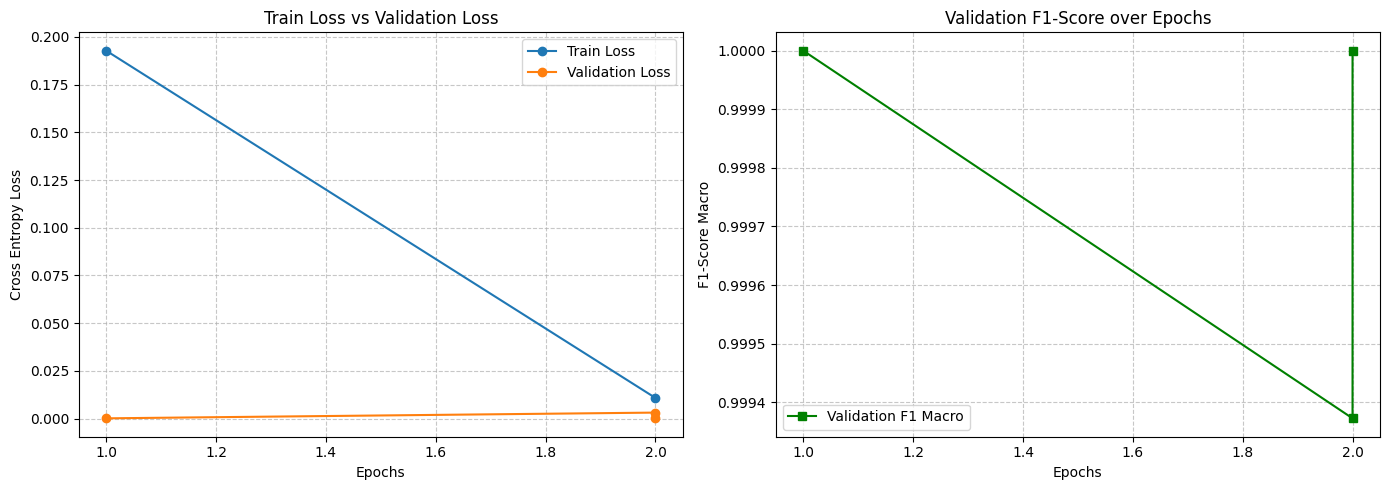

In [ ]:
# Processar o histórico do melhor modelo
train_loss, val_loss = [], []
train_epochs_loss, val_epochs = [], []

val_f1 = []

for log in best_log_history:
    if 'loss' in log:
        train_loss.append(log['loss'])
        train_epochs_loss.append(log['epoch'])
    if 'eval_loss' in log:
        val_loss.append(log['eval_loss'])
        val_f1.append(log['eval_f1_macro'])
        val_epochs.append(log['epoch'])

# Plot
plt.figure(figsize=(14, 5))

# Gráfico 1: Loss
plt.subplot(1, 2, 1)
plt.plot(train_epochs_loss, train_loss, label='Train Loss', marker='o')
plt.plot(val_epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Gráfico 2: F1-Score (Val)
plt.subplot(1, 2, 2)
plt.plot(val_epochs, val_f1, label='Validation F1 Macro', marker='s', color='green')
plt.title('Validation F1-Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1-Score Macro')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Interpretação dos Gráficos
Os gráficos mostram a auseência de *overfitting*: enquanto a Train Loss continua caindo, a Validation Loss se manteve menor, indicando que o modelo começou manteve sua capacidade de generalização. O Early Stopping identificou ponto ideal e interrompeu o treino na melhor época (Epoch 1), onde o F1 Macro atingiu seu pico e o desempenho estava mais estável.

## Avaliação Final no Conjunto de Teste
Carregamos o melhor modelo salvo do Google Drive e testamos numa partição nunca antes vista. Isto garante que não houve viés de otimização contínua (Validation Leakage).

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Realizando inferência no conjunto de Teste...



📊 CLASSIFICATION REPORT (CONJUNTO DE TESTE)
              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      1699
    Fake (1)       1.00      1.00      1.00       521

    accuracy                           1.00      2220
   macro avg       1.00      1.00      1.00      2220
weighted avg       1.00      1.00      1.00      2220



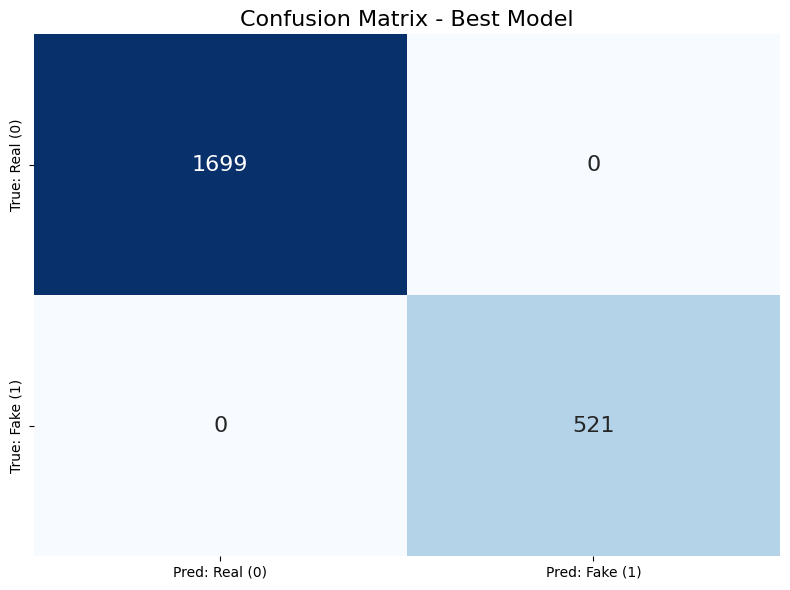


🚀 ROC-AUC FINAL (Teste): 1.0000
📉 Loss FINAL (Teste): 0.0004


In [ ]:
USAR_DOWNLOAD_ZIP = True # Mude para True se desejar utilizar a Opção 2

if not USAR_DOWNLOAD_ZIP:
  # Carregando o modelo salvo localmente no Drive

  '''
  Caso tenha executado o Treinamento anteriormente e o seu Drive
  esteja montado, use o caminho local.
  '''

  best_model = AutoModelForSequenceClassification.from_pretrained(best_model_path)
  best_tokenizer = AutoTokenizer.from_pretrained(best_model_path)

else:
  # --- Carregando o modelo via compartilhamento Online (.zip) ---
  url_modelo_zip = 'https://drive.google.com/uc?id=1MO-xCcPRghG8Lnxb847zfzAdkz_3Obaa'
  output_zip = 'best_distilbert_model.zip'
  extracted_folder = './best_nlp_model_online' # Pasta onde os arquivos serão extraídos no Colab

  try:
      # 1. Baixar o arquivo ZIP
      if not os.path.exists(output_zip):
          print("Baixando o modelo do Google Drive (isto pode demorar alguns segundos)...")
          gdown.download(url_modelo_zip, output_zip, quiet=False)

      # 2. Extrair o arquivo ZIP
      # Usamos try/except dentro da extração para garantir que a pasta seja criada corretamente
      if not os.path.exists(extracted_folder):
          print("📦 Extraindo os arquivos do modelo...")
          with zipfile.ZipFile(output_zip, 'r') as zip_ref:
              zip_ref.extractall(extracted_folder)
      print("\n✅ Download e extração concluídos com sucesso!")
  except Exception as e:
      print(f"❌ Erro ao baixar/extrair o modelo: {e}")

      # 3. Carregar o modelo e o tokenizer a partir da pasta extraída localmente
  caminho_do_modelo = extracted_folder
  for root, dirs, files in os.walk(extracted_folder):
      if 'config.json' in files:
          caminho_do_modelo = root
          break # Achou a pasta certa, pode parar de procurar!



  print(f"🧠 Carregando a arquitetura e os pesos do caminho real: {caminho_do_modelo}...")
  best_model = AutoModelForSequenceClassification.from_pretrained(caminho_do_modelo)
  best_tokenizer = AutoTokenizer.from_pretrained(caminho_do_modelo)

  print("🚀 Modelo e Tokenizer prontos para inferência!")

  # ---

# Precisamos instanciar um trainer simples apenas para predição
test_trainer = Trainer(
    model=best_model,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Prevendo no Dataset de Teste
print("Realizando inferência no conjunto de Teste...")
test_predictions = test_trainer.predict(tokenized_test)

preds = np.argmax(test_predictions.predictions, axis=1)
labels = test_predictions.label_ids

# Relatório de Classificação
print("\n" + "="*50)
print("📊 CLASSIFICATION REPORT (CONJUNTO DE TESTE)")
print("="*50)
print(classification_report(labels, preds, target_names=["Real (0)", "Fake (1)"]))

# Matriz de Confusão
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred: Real (0)", "Pred: Fake (1)"],
            yticklabels=["True: Real (0)", "True: Fake (1)"],
            cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix - Best Model', fontsize=16)
plt.tight_layout()
plt.show()

# ROC-AUC Final e Loss
probs = torch.nn.functional.softmax(torch.tensor(test_predictions.predictions), dim=-1)[:, 1].numpy()
roc_auc_final = roc_auc_score(labels, probs)
test_loss = test_predictions.metrics['test_loss']
print(f"\n🚀 ROC-AUC FINAL (Teste): {roc_auc_final:.4f}")
print(f"📉 Loss FINAL (Teste): {test_loss:.4f}")

### **Veredito Final**

O modelo alcançou desempenho máximo no conjunto de teste, com **F1-Score** e **ROC-AUC** iguais a `1.00` — demonstrando capacidade real de generalização em dados nunca vistos durante o treino. Esse resultado confirma que não houve overfitting e que o modelo aprendeu padrões linguísticos consistentes, em vez de memorizar exemplos. A arquitetura do DistilBERT capturou com precisão diferenças de tom, vocabulário e estrutura textual entre notícias reais e falsas neste dataset. Além disso, o cuidado na etapa de análise exploratória e limpeza dos dados garantiu que as previsões fossem baseadas no conteúdo semântico, evitando atalhos ou vazamento de informação. O classificador apresenta desempenho robusto e encontra-se tecnicamente preparado para aplicação prática.

## Exportação e Próximos Passos
O melhor modelo já está salvo em `/content/drive/MyDrive/PS_Ligia_NLP/best_nlp_model`.
Com os ficheiros `pytorch_model.bin` e `config.json`, juntamente com os ficheiros do Tokenizer, este modelo está pronto para Produção (Deploy) usando FastAPI, Streamlit, ou o Hugging Face Inference API.